# 개요
이 노트북은 HW3의 결과로 얻은 최적의 파라미터로 모델을 훈련시키는 과정을 재현합니다.

훈련 과정의 무작위성을 감안하여 같은 하이퍼파라미터로 3번 훈련시킵니다.

# 사용법
처음부터 끝까지 실행시키면 됩니다.

# ❗주의 ❗
마찬가지의 이유로 구글 계정 및 구글 드라이브 연동이 필요합니다.

# GPU 사용

코랩의 GPU 사용을 위한 설정입니다

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# 라이브러리 설치

BOHB를 위한 라이브러리는 Colab에 기본으로 설치되어 있지 않기 때문에 별도로 설치합니다.

In [2]:
!pip install hpbandster
!pip install ConfigSpace

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for hpbandster: filename=hpbandster-0.7.4-py3-none-any.whl size=79991 sha256=f8bfb4b00a9861f15cbc6ff19b9fbb884107ff40fb81e3f7465fb402973778ef
  Stored in directory: /root/.cache/pip/wheels/79/51/18/33d6ba8c55cc8401bffbccb1b87b21e0c68f40edc4ce3c1f99
  Created wheel for netifaces: filename=netifaces-0.11.0-cp310-cp310-linux_x86_64.whl size=35006 sha256=6bd2bd2415691cfe71d9df63233586132a599234750514b58f3c67a2ac085779
  Stored in directory: /root/.cache/pip/wheels/48/65/b3/4c4cc6038b81ff21cc9df69f2b6774f5f52e23d3c275ed15aa
Successfully built hpbandster netifaces


# 전처리(데이터 다운로드 및 나누기)

간단한 전처리입니다.

In [3]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# 데이터셋 로드
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 데이터 전처리
x_train = x_train.reshape(-1, 28*28).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28*28).astype('float32') / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# 2.4. train data를 4:1로 분할하여 validation data 생성
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)


11490434/11490434 [==============================] - 1s 0us/step


# 데이터 증강

과적합을 방지하기 위한 데이터 증강입니다.

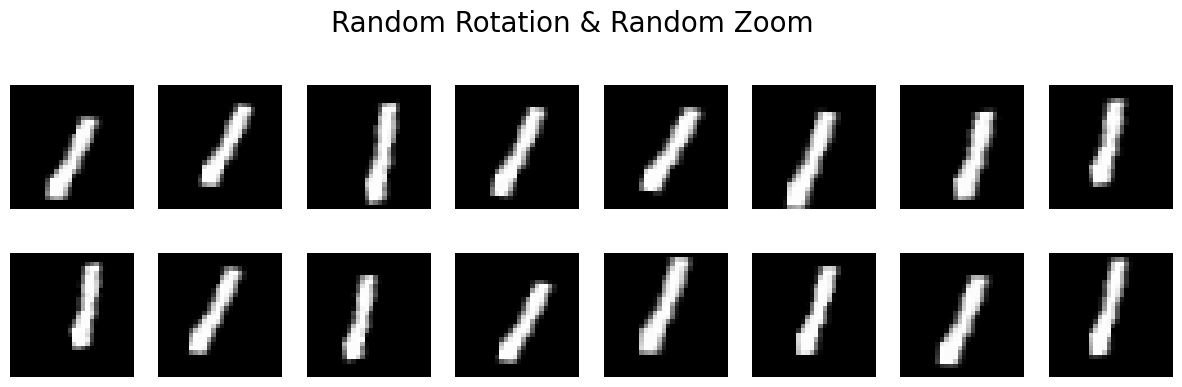

In [4]:
# 3. 데이터 증강
from keras.preprocessing.image import ImageDataGenerator
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    fill_mode = 'nearest'
)

aug = datagen.flow(x_train[2].reshape(-1, 28, 28, 1))

# Plot using a for loop
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 8, figsize = (15, 4))
plt.suptitle('Random Rotation & Random Zoom', fontsize=20, y=1.05)
axes = axes.ravel()

for i in range(16):

    aug_img = next(aug)[0]
    axes[i].imshow(aug_img, cmap = 'gray')
    axes[i].axis('off')

plt.show()

# 모델 정의

In [5]:
from tensorflow.keras import layers, models, regularizers, optimizers, callbacks, metrics
from tensorflow.keras.callbacks import ReduceLROnPlateau
def create_model(
    num_hidden_layers=3,
    hidden_units=1024,
    dropout_rate=0.0,
    l2_regularizer=0.01,
    momentum=0.9,
    reduce_lr_factor=0.2,
    reduce_lr_patience=4,
    initial_learning_rate=0.01,
):
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28, 1)))

    for _ in range(num_hidden_layers):
        model.add(layers.Dense(hidden_units, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(l2_regularizer)))
        model.add(layers.BatchNormalization())  # 활성화 함수 이전에 배치 정규화 적용
        model.add(layers.Activation('relu'))  # 활성화 함수 분리
        model.add(layers.Dropout(dropout_rate))


    model.add(layers.Dense(10, activation='softmax'))

    optimizer=optimizers.SGD(momentum=momentum, learning_rate = initial_learning_rate)
    reduce_lr = ReduceLROnPlateau(
        monitor='val_categorical_accuracy',
        factor=reduce_lr_factor,
        patience=reduce_lr_patience,
        verbose=1
    )

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    return model, reduce_lr


# 훈련 로그 저장소 초기화
Google 드라이브 저장소에 훈련 로그를 저장하기 위한 폴더를 생성합니다.
폴더가 이미 있다면 내용을 지웁니다.

In [6]:
import os
from google.colab import drive

# Google Drive 마운트
drive.mount('/content/drive')
SAVE_DIR = '/content/drive/My Drive/HW3_test_results'  # 저장할 경로 설정

def reset_model_storage(save_dir=SAVE_DIR):
    if os.path.exists(save_dir):
        # 디렉토리 내 모든 파일 삭제
        for filename in os.listdir(save_dir):
            file_path = os.path.join(save_dir, filename)
            try:
                if os.path.isfile(file_path):
                    os.unlink(file_path)  # 파일 삭제
                elif os.path.isdir(file_path):
                    os.rmdir(file_path)  # 디렉토리 삭제 (비어 있을 경우)
            except Exception as e:
                print(f'Error deleting {file_path}: {e}')
        print(f"모델 저장소 {save_dir}가 초기화되었습니다.")
    else:
        print(f"{save_dir} 디렉토리가 존재하지 않습니다.")

# 모델 저장소 초기화 함수 실행
reset_model_storage()

Mounted at /content/drive
/content/drive/My Drive/HW3_test_results 디렉토리가 존재하지 않습니다.


# 학습 정의 및 하이퍼 파라미터 범위 정의



In [7]:
import hpbandster.core.nameserver as hpns
import hpbandster.core.result as hpres

from hpbandster.optimizers import BOHB


import ConfigSpace as CS
from tensorflow.keras.callbacks import EarlyStopping
from hpbandster.core.worker import Worker

class MyWorker(Worker):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def compute(self, config, budget, *args, **kwargs):
        print("Hyperparameters:", config)  # 현재 하이퍼파라미터 출력

        #num_hidden_layers = config['num_hidden_layers']
        #hidden_units = 2 ** config['hidden_units_exp']  # 2의 거듭제곱으로 변환
        dropout_rate = config['dropout_rate']
        l2_regularizer = config['l2_regularizer']
        momentum = config['momentum']
        reduce_lr_factor = config['reduce_lr_factor']
        #reduce_lr_patience = config['reduce_lr_patience']
        initial_learning_rate = config['initial_learning_rate']  # 'initial_learning_rate

        num_hidden_layers = 5
        hidden_units = 2 ** 10
        reduce_lr_patience = 5

        model, reduce_lr = create_model(
            num_hidden_layers,
            hidden_units,
            dropout_rate,
            l2_regularizer,
            momentum,
            reduce_lr_factor,
            reduce_lr_patience,
            initial_learning_rate,
        )

        # EarlyStopping 콜백 정의
        early_stopping = EarlyStopping(
            monitor='val_categorical_accuracy',  # 검증 손실 기반으로 모니터링
            patience=8,           # 8 에폭 동안 성능 향상이 없으면 학습 조기 종료
            restore_best_weights=True  # 최적의 가중치로 복원
        )

        model.fit(
            datagen.flow(x_train.reshape(-1, 28, 28, 1), y_train, batch_size=128),  # 데이터 증강 적용
            epochs=int(budget),
            verbose=1,
            validation_data=(x_val.reshape(-1, 28, 28, 1), y_val),
            callbacks=[reduce_lr, early_stopping],
        )

        loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
        return {'loss': -accuracy, 'info': {'test_accuracy': accuracy}}

def get_configspace():
    cs = CS.ConfigurationSpace()
    cs.add_hyperparameters([
        #CS.UniformIntegerHyperparameter('num_hidden_layers', lower=1, upper=5, default_value=3),
        #CS.UniformIntegerHyperparameter(
        #    'hidden_units_exp',
        #    lower=7,
        #    upper=10,
        #    default_value=10
        #),
        CS.UniformFloatHyperparameter('dropout_rate', lower=0.167, upper=0.168, default_value=0.1677),
        CS.UniformFloatHyperparameter('l2_regularizer', lower=0.000388, upper=0.0003881, log=True, default_value=0.00038808),
        CS.UniformFloatHyperparameter('momentum', lower=0.822, upper=0.823, default_value=0.8222),
        CS.UniformFloatHyperparameter('reduce_lr_factor', lower=0.132, upper=0.133, default_value=0.1327),
        #CS.UniformIntegerHyperparameter('reduce_lr_patience', lower=2, upper=6, default_value=4),
        CS.UniformFloatHyperparameter('initial_learning_rate', lower=0.0611, upper=0.06111, log=True, default_value=0.061109)
    ])
    return cs



# 구글 드라이브 설정

In [8]:
import os
import json
import time
from google.colab import drive
# Google Drive 마운트
drive.mount('/content/drive')
SAVE_DIR = '/content/drive/My Drive/HW3_test_results'  # 저장할 경로 설정

# 결과 저장 폴더 생성 (없을 경우)
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 재현
무작위성을 감안하여 같은 하이퍼파라미터로 50 epoch를 3번 수행합니다.

In [9]:
import os
import pickle
import hpbandster.core.result as hpres
from hpbandster.core.result import json_result_logger

result_logger = hpres.json_result_logger(directory=SAVE_DIR, overwrite=True)

# 네임 서버와 워커를 새로 시작하는 함수
def start_new_ns_and_workers():
    global NS, w
    NS = hpns.NameServer(run_id='bohb', host='127.0.0.1', port=9090)  # 포트를 명시적으로 설정
    NS.start()
    w = MyWorker(nameserver='127.0.0.1', nameserver_port=9090, run_id='bohb')  # 동일한 포트로 설정
    w.run(background=True)
    time.sleep(2)  # 잠시 대기하여 워커가 네임 서버에 연결될 시간을 줍니다.

start_new_ns_and_workers()

# BOHB 설정
try:
    bohb = BOHB(
        configspace=get_configspace(),
        run_id='bohb',
        nameserver='127.0.0.1',
        min_budget=50,
        max_budget=50,
        result_logger=result_logger,  # 결과 로거 설정
    )

    # BOHB 실행 및 결과 저장
    for i in range(3): # <-- 여기를 수정하면 epoch 수를 수정할 수 있습니다.
        result = bohb.run(n_iterations=1)
        print("current iter: ", result.num_iterations())
        # iteration 종료 시 결과 저장
        # 결과 저장
        with open(os.path.join(SAVE_DIR, 'results.pkl'), 'wb') as fh:
            pickle.dump(result, fh)
except KeyboardInterrupt:
    print("\n작업이 중단되었습니다. 마지막 Iteration까지 결과가 저장되었습니다.")
finally:
    bohb.shutdown(shutdown_workers=True)
    NS.shutdown()

Hyperparameters: {'dropout_rate': 0.16720280387812197, 'initial_learning_rate': 0.06110981046413328, 'l2_regularizer': 0.0003880406022946974, 'momentum': 0.8225754200143486, 'reduce_lr_factor': 0.13257183981181284}
Epoch 1/50
375/375 [==============================] - 19s 38ms/step - loss: 4.2675 - categorical_accuracy: 0.8238 - val_loss: 3.5532 - val_categorical_accuracy: 0.9508 - lr: 0.0611
Epoch 2/50
375/375 [==============================] - 14s 37ms/step - loss: 3.3880 - categorical_accuracy: 0.9120 - val_loss: 2.9420 - val_categorical_accuracy: 0.9655 - lr: 0.0611
Epoch 3/50
375/375 [==============================] - 14s 37ms/step - loss: 2.8205 - categorical_accuracy: 0.9264 - val_loss: 2.4535 - val_categorical_accuracy: 0.9690 - lr: 0.0611
Epoch 4/50
375/375 [==============================] - 14s 37ms/step - loss: 2.3657 - categorical_accuracy: 0.9340 - val_loss: 2.0562 - val_categorical_accuracy: 0.9718 - lr: 0.0611
Epoch 5/50
375/375 [==============================] - 14s 37m

# 정확도 그래프

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


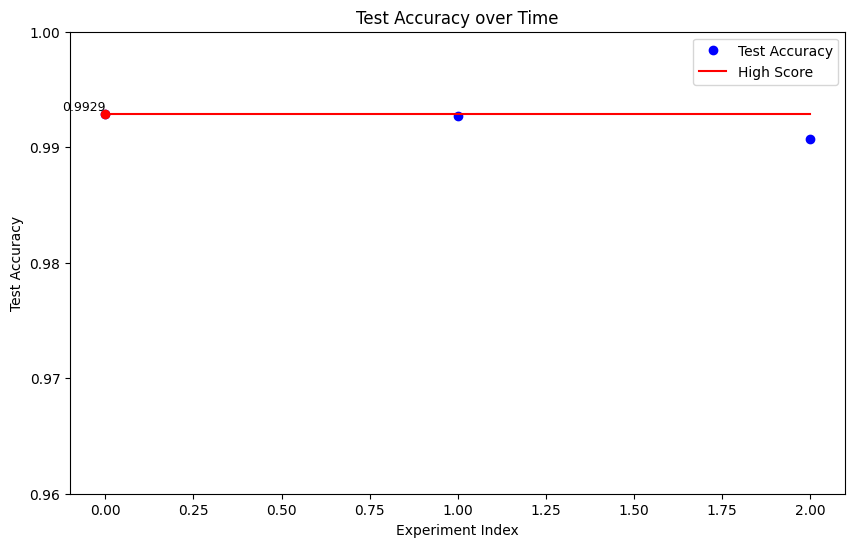

In [11]:
import json
import pickle
import matplotlib.pyplot as plt
import os
from google.colab import drive

# Google Drive 마운트
drive.mount('/content/drive')
SAVE_DIR = '/content/drive/My Drive/HW3_test_results'  # 저장할 경로 설정
# 저장된 결과 파일 경로
result_file = os.path.join(SAVE_DIR, 'results.pkl')

# 결과 불러오기
with open(result_file, 'rb') as f:
    result = pickle.load(f)

# get all executed runs
all_runs = result.get_all_runs()

# get the 'dict' that translates config ids to the actual configurations
id2conf = result.get_id2config_mapping()

# budget = 50인 실험 결과 추출
results = []
for entry in all_runs:
        test_accuracy = entry['info']['test_accuracy']
        results.append(test_accuracy)

# 실험 인덱스 생성
indices = range(len(results))

# 최고 테스트 정확도 값 추적
max_accuracy = []
current_max = 0
for accuracy in results:
    if accuracy > current_max:
        current_max = accuracy
    max_accuracy.append(current_max)

# 테스트 정확도 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(indices, results, 'bo', label='Test Accuracy')

# 최고 기록 점 표시
for i, (x, y) in enumerate(zip(indices, results)):
    if y == max_accuracy[i]:
        plt.plot(x, y, 'ro')
        plt.text(x, y, f'{y:.4f}', fontsize=9, verticalalignment='bottom', horizontalalignment='right')

# 최고 기록을 잇는 선 그리기
plt.plot(indices, max_accuracy, 'r-', label='High Score')

# 세밀한 y축 범위 설정
plt.ylim(0.96, 1.0)
plt.yticks([0.96, 0.97, 0.98, 0.99, 1.0])

# 그래프 라벨 및 제목 추가
plt.xlabel('Experiment Index')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy over Time')
plt.legend()
plt.show()
